# Description

This notebook implements the VAE LSTM model. All the code was written by our Deep Learning project team. 
Additional external code is imported. You will first find the tool functions 
for generating the data and building the models. 
Then, at the bottom of the notebook you will find the experiments with plots and results used in our report. 

You can find the customized loss function in the `Tool Functions` part of the code below. It is called 
`reconstruction_loss`. 

# Imports

In [2]:
## Network Processing
import networkx as nx 
from barabasi_albert import barabasi_albert_graph

## Matrix Processing
import numpy as np
import pandas as pd
import scipy as sp

## VAE LSTM
import keras.backend as K
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Lambda, LSTM, \
                Conv1DTranspose, Conv2DTranspose, Permute, Bidirectional
from multi_graph_cnn_layer import MultiGraphCNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data Processing
from sklearn.utils import shuffle

## External tool functions
from utils import *

## Error metrics
from sklearn.metrics import mean_squared_error, r2_score

## Pseudorandom number generator
from random import seed
from random import randint

## Plotting 
import matplotlib.pyplot as plt

# TOOL FUNCTIONS

### Data Generation

In [3]:
def generate_barabasi_adj_matrix(n, m, alpha=1):
    """Generates a Barabasi Alert graph and returns an adjacency matrix with
     a node ordering defined by the networkx Graph library"""
    
    assert n <= N_MAX, 'n must be less or equal that N_MAX'
    
    adj_matrix = np.zeros((N_MAX, N_MAX))
        
    networkx_graph = barabasi_albert_graph(n, m, alpha, seed=SEED)
    sparse_matrix = nx.linalg.graphmatrix.adjacency_matrix(networkx_graph, nodelist=None, weight=None)
    
    adj_matrix[:n, :n] = sparse_matrix.todense()
    
    return adj_matrix

In [4]:
def generate_multi_barabasi_graphs(nb_graphs, scenario_type):
    """Generates 'nb_graphs' Barabasi graphs. Each graph has 'n' nodes, the first 
    parameter of the Barabasi-Albert model, where 'n' is selected in a different way depending 
    of the 'scenario_type', as well as 'm' and 'alpha'.
    The function outputs the adjacency matrices, the feature matrices (identity matrices) 
    and the parameters n and m used in the data generation process"""
    
    # Each matrix generated during the graph generation process is vertically concatenated to the output
    adjacency_matrices = np.zeros((nb_graphs*N_MAX, N_MAX))
    feature_matrices = np.zeros((nb_graphs*N_MAX, N_MAX))
    parameter_vectors = np.zeros((nb_graphs, LATENT_SPACE_SIZE))

    for sample_graph_index in range(nb_graphs):
        
        if scenario_type == 0:
            # n is constant, m is constant and alpha = 1
            n = N_MIN
            m = N_MIN-1
            alpha = 1
            
        if scenario_type == 1:
            # n is constant, m varies and alpha = 1
            n = N_MIN
            m = randint(1, n-1)
            alpha = 1
            
        if scenario_type == 2:
            # n varies, m is proportional to n and alpha = 1
            n = randint(N_MIN, N_MAX)
            m = max(1, int(n / 3.0))
            alpha = 1
            
        if scenario_type == 3:
            # n varies, m varies and alpha = 1
            n = randint(N_MIN, N_MAX)
            m = randint(1, n-1)
            alpha = 1
            
        if scenario_type == 4:
            # n varies, m varies and alpha varies in [0,1]
            n = randint(N_MIN, N_MAX)
            m = randint(1, n-1)
            alpha = np.random.uniform()
        
        # Generate Barabasi Graph adjacency matrix
        adj_matrix = generate_barabasi_adj_matrix(n, m, alpha)

        # Update output matrices
        row_start_index = N_MAX * sample_graph_index
        
        adjacency_matrices[row_start_index: row_start_index + N_MAX, :] = adj_matrix
        feature_matrices[row_start_index: row_start_index + n, :n] = np.eye(n)
        parameter_vectors[sample_graph_index, :] = [n, m, alpha]
    
    return adjacency_matrices, feature_matrices, parameter_vectors

In [5]:
def format_data(A, X, Y):
    """
    Format the data such that it is a matrix of matrices (a batch containing sample matrices)
    """

    # Load and prepare the adjacency matrices
    num_graph_nodes = A.shape[1]
    num_graphs = int(A.shape[0]/A.shape[1])

    A = np.split(A, num_graphs, axis=0)
    A = np.array(A)

    # Load and prepare the feature matrices
    X = np.split(X, num_graphs, axis=0)
    X = np.array(X)

    # Shuffle data before training
    A, X, Y = shuffle(A, X, Y)
    
    return A, X, Y 

### VAE LSTM

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
def get_mask(step):
    """
    Tool function used in the customized loss. Create a mask that select a specific step of the 
    output sequence of graphs in the LSTM. 
    """
    
    if step > 0: 
          
        mask_zeros_before = tf.fill([BATCH_SIZE_VAE, step, N_MAX, N_MAX], 0.0)
        mask_ones = tf.fill([BATCH_SIZE_VAE, 1, N_MAX, N_MAX], 1.0)
        mask_zeros_after = tf.fill([BATCH_SIZE_VAE, N_MAX-step-1, N_MAX, N_MAX], 0.0)
        
        mask = tf.concat([mask_zeros_before, mask_ones, mask_zeros_after], axis=1)
    
    else:
        
        mask_ones = tf.fill([BATCH_SIZE_VAE, 1, N_MAX, N_MAX], 1.0)
        mask_zeros_after = tf.fill([BATCH_SIZE_VAE, N_MAX-1, N_MAX, N_MAX], 0.0)
        mask = tf.concat([mask_ones, mask_zeros_after], axis=1)
        
    return mask

In [8]:
def reconstruction_loss(y_true, y_pred):
    """
    Customized reconstruction loss. It ensures that the output sequence of the LSTM corresponds to 
    valid adjacency matrices (symmetric, trace equals 0) and that the first graph is empty, the last 
    graph has similar propreties as the input graph (same number of nodes, number of edges, 
    degree distribution) and the graphs in between have increasing number of nodes and edges.
    """
    
    y_pred = K.reshape(y_pred, shape = (BATCH_SIZE_VAE, N_MAX, N_MAX, N_MAX))   
    reconstruction_loss = tf.fill([BATCH_SIZE_VAE, N_MAX], 0.0)
             
    ## Loss all steps
     
    # Ensures symmetry
    t_transpose = tf.transpose(y_pred, perm=[0, 1, 3, 2])
    non_symmetry_loss = y_pred - t_transpose
    non_symmetry_loss = non_symmetry_loss * non_symmetry_loss
    non_symmetry_loss = tf.math.reduce_sum(non_symmetry_loss, axis=[-1,-2])
    reconstruction_loss += non_symmetry_loss
    
    # Ensures that the trace is 0
    trace_mask = np.repeat(np.zeros((N_MAX, N_MAX)), N_MAX).reshape((N_MAX, N_MAX, N_MAX))
    for i in range(len(trace_mask)):
        trace_mask[i,:,:] = np.eye(N_MAX)
    trace_mask = tf.constant(trace_mask, dtype=tf.dtypes.float32)
    trace_loss = y_pred * trace_mask
    trace_loss = tf.math.reduce_sum(trace_loss, axis=[-1,-2])
    trace_loss = trace_loss * trace_loss
    reconstruction_loss += trace_loss
    
    # Ensures that there is an increasing number of nodes
    sum_per_step = tf.math.reduce_sum(y_pred, axis=[-1,-2])
    sum_per_step_rolled = tf.roll(sum_per_step, shift=1, axis=1)
    first_step_mask = np.zeros((BATCH_SIZE_VAE, N_MAX))
    first_step_mask[:, 0] = np.ones((BATCH_SIZE_VAE, 1)).flatten()
    sum_per_step_rolled = sum_per_step_rolled * (1 - first_step_mask) + sum_per_step * first_step_mask
    sum_per_step_loss = sum_per_step - sum_per_step_rolled
    sum_per_step_loss = tf.math.maximum(tf.fill([BATCH_SIZE_VAE, N_MAX], 0.0), -1*sum_per_step_loss-1)
    sum_per_step_loss = sum_per_step_loss * sum_per_step_loss
    reconstruction_loss += sum_per_step_loss
    
    # Ensures that there is an increasing number of edges
    degree_per_step_rolled = tf.roll(y_pred, shift=1, axis=1)
    first_step_mask = np.zeros((BATCH_SIZE_VAE, N_MAX, N_MAX, N_MAX))
    first_step_mask[:, 0, :, :] = \
                    np.repeat(np.ones((N_MAX, N_MAX)), BATCH_SIZE_VAE).reshape((BATCH_SIZE_VAE, N_MAX, N_MAX))
    degree_per_step_rolled = degree_per_step_rolled * (1 - first_step_mask) + y_pred * first_step_mask
    degree_per_step_loss = y_pred - degree_per_step_rolled
    degree_per_step_loss = \
        tf.math.maximum(tf.fill([BATCH_SIZE_VAE, N_MAX, N_MAX, N_MAX], 0.0), -1*degree_per_step_loss)
    degree_per_step_loss = tf.math.reduce_sum(degree_per_step_loss, axis=[-1,-2])
    degree_per_step_loss = degree_per_step_loss * degree_per_step_loss
    reconstruction_loss += degree_per_step_loss
        
    # From step loss to global loss
    reconstruction_loss = tf.math.reduce_sum(reconstruction_loss, axis=-1)
    
    ## Loss first step
    
    # Ensures that we start with an empty graph 
    mask_first_step = get_mask(step=0)   
    y_pred_first_step = y_pred * mask_first_step
    first_step_loss = tf.math.reduce_sum(y_pred_first_step, axis=[-1,-2])
    first_step_loss = tf.math.reduce_sum(first_step_loss, axis=-1)
    first_step_loss = first_step_loss * first_step_loss
    reconstruction_loss += first_step_loss
    
    ## Loss last step
    mask_last_step = get_mask(step=N_MAX-1)
    y_pred_last_step = y_pred * mask_last_step
    
    # Ensures that the last graph has the same number of edges than input graph
    sum_degrees_loss = tf.math.reduce_sum(y_pred_last_step, axis=[-1,-2])
    sum_degrees_loss = tf.math.reduce_sum(sum_degrees_loss, axis=-1)
    a_degrees = tf.math.reduce_sum(y_true, axis=[-1,-2])
    sum_degrees_loss = (sum_degrees_loss - a_degrees) * (sum_degrees_loss - a_degrees) 
    sum_degrees_loss = sum_degrees_loss * sum_degrees_loss
    reconstruction_loss += sum_degrees_loss
       
    # Ensures that the last graph has the same edge distribution than input graph
    ordered_degrees_pred = tf.math.reduce_sum(y_pred_last_step, axis=-1)
    ordered_degrees_pred = tf.math.reduce_sum(ordered_degrees_pred, axis=-2)
    ordered_degrees_pred = tf.sort(ordered_degrees_pred,axis=-1)
    ordered_degrees_true = tf.math.reduce_sum(y_true, axis=-1)
    ordered_degrees_true = tf.sort(ordered_degrees_true,axis=-1)
    ordered_degrees_loss = (ordered_degrees_pred-ordered_degrees_true)* \
                            (ordered_degrees_pred-ordered_degrees_true)
    ordered_degrees_loss = tf.math.reduce_sum(ordered_degrees_loss, axis=-1)
    ordered_degrees_loss = ordered_degrees_loss * ordered_degrees_loss
    reconstruction_loss += ordered_degrees_loss
    
    kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
    kl_degree_distribution_loss = tf.math.round(kl(ordered_degrees_true, ordered_degrees_pred))
    kl_degree_distribution_loss *= KL_WEIGHT
    reconstruction_loss += kl_degree_distribution_loss
    
    variance_degrees_pred = tf.math.reduce_std(ordered_degrees_pred, axis=1)
    variance_degrees_true = tf.math.reduce_std(ordered_degrees_true, axis=1)
    variance_degrees_loss = (variance_degrees_pred - variance_degrees_true) * \
                            (variance_degrees_pred - variance_degrees_true)
    variance_degrees_loss = variance_degrees_loss * variance_degrees_loss
    reconstruction_loss += variance_degrees_loss
    
    # Ensures that the last graph has the same number of nodes than input graph
    binary_last_step = tf.math.round(y_pred_last_step)
    n_pred = tf.math.reduce_sum(binary_last_step, axis=-1)
    n_pred = tf.math.minimum(tf.fill([BATCH_SIZE_VAE, N_MAX, N_MAX], 1.0), n_pred)
    n_pred = tf.math.reduce_sum(n_pred, axis=[-1, -2])
    n_true = tf.math.reduce_sum(y_true, axis=-1)
    n_true = tf.math.minimum(tf.fill([BATCH_SIZE_VAE, N_MAX], 1.0), n_true)
    n_true = tf.math.reduce_sum(n_true, axis=-1)
    n_loss = (n_true - n_pred) * (n_true - n_pred)
    n_loss = n_loss * n_loss
    reconstruction_loss += n_loss
        
    return reconstruction_loss

In [9]:
def latent_space_loss(y_true, y_pred):
    """
    Make sure that the latent variable are positives. This is not a necessary requirement, but helps 
    for plotting and could help the network to interpret the latent as model parameters. 
    """

    positive_params_loss = tf.math.maximum(tf.fill([BATCH_SIZE_VAE, LATENT_SPACE_SIZE], 0.0), -1*y_pred)
    positive_params_loss = tf.math.reduce_sum(positive_params_loss, axis=1)   
    
    return positive_params_loss

In [10]:
def build_encoder(X_input_shape, graph_conv_filters_input_shape, num_filters):
    """
    Build the GCN encoder along with the sampling layer. 
    """    
    
    X_input = Input(shape=X_input_shape)
    graph_conv_filters_input = Input(shape=graph_conv_filters_input_shape)

    ######## ENCODER #######
    
    output = MultiGraphCNN(200, num_filters, activation='elu')([X_input, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    output = MultiGraphCNN(200, num_filters, activation='elu')([output, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    
    # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
    output = Lambda(lambda x: K.mean(x, axis=1))(output)  
    
    output = Dense(256)(output)
    output = Dense(128)(output)
    output = Dense(64)(output)
    output = Dense(32)(output)
    output = Dense(16)(output)
    output = Dense(4)(output)
    
    # Sampling layer for VAE
    z_mean = layers.Dense(LATENT_SPACE_SIZE, name='z_mean')(output)
    z_log_var = layers.Dense(LATENT_SPACE_SIZE, name='z_log_var')(output)
    z = Sampling(name='latent_space')([z_mean, z_log_var])
    
    
    encoder = Model(
        inputs=[X_input, graph_conv_filters_input], 
        outputs=[z_mean, z_log_var, z], 
        name="encoder")
    
    return encoder

In [11]:
def build_decoder():
    """
    Build the decoder with transpode 1D convolutions to create the graph embeddings and then 
    the LSTM layer for the sequential graph generation. 
    """
    
    latent_inputs = Input(shape=(LATENT_SPACE_SIZE,))
    
    ######## DECODER #######
    
    # From parameters to node embeddings
    output = tf.keras.backend.expand_dims(latent_inputs, axis=2)
    output = Conv1DTranspose(filters=N_MAX, kernel_size=2, strides=1)(output)
    output = Permute((2, 1))(output)
    
    # From parameters to graph embeddings    
    output = Dense(N_MAX*N_MAX)(output)
    
    # Sequential modeling
    output = LSTM(N_MAX*N_MAX, return_sequences=True, activation='sigmoid', name='lstm')(output)
    
    ###### COMPILE ######## 
    decoder = Model(latent_inputs, outputs=output, name="decoder")
    
    return decoder

In [12]:
class VAE(keras.Model):
    """
    VAE class combining encoder and decoder and defining the forward step. 
    """
    
    def __init__(self, F_shape, X_shape, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # Build encoder
        num_filters = 2
        self.encoder = build_encoder(X_shape, F_shape, num_filters)
        
        # Build decoder
        self.decoder = build_decoder()

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            rec_loss = reconstruction_loss(data[0], reconstruction) / RECONSTRUCTION_NORMALIZATION
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
                        
            total_loss =  rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": rec_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def get_latent_values(self, inputs):
        latent_space_layer = Model(inputs=self.encoder.input, 
                                   outputs=self.encoder.get_layer('latent_space').output)
        latent_pred = latent_space_layer.predict(inputs)
        return latent_pred

In [13]:
def fit_vae(A, X):
    """
    Format training data and train VAE. 
    """
        
    # build graph_conv_filters
    num_filters = 2
    graph_conv_filters = preprocess_adj_tensor_with_identity(A, SYM_NORM)
    
    model = VAE((graph_conv_filters.shape[1], graph_conv_filters.shape[2]), (X.shape[1], X.shape[2]))    
    model.compile(optimizer=keras.optimizers.Adam())       
    model.fit([X, graph_conv_filters], A, batch_size=BATCH_SIZE_VAE, \
              epochs=NB_EPOCHS_VAE, shuffle=True, verbose=0)
    
    return model

### H function

In [14]:
def build_h(X_input_shape):
    """
    Build the H function mapping the latent space to the generative parameters.  
    """
        
    X_input = Input(shape=X_input_shape)
    
    ######## Dense Network #######
    
    output = Dense(8)(X_input)
    output = Dense(16)(output)
    output = Dense(8)(output)
    output = Dense(X_input_shape)(output)
       
    model = Model(inputs=X_input, outputs=output)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [15]:
def fit_h(X_train, y_train):
    """
    Build and train the H function. 
    """
            
    model = build_h(X_train.shape[1])  
    model.fit(X_train, y_train, batch_size=BATCH_SIZE_H, epochs=NB_EPOCHS_H, shuffle=True, verbose=0)
    
    return model

In [16]:
def predict_h(model, X):
    """
    Predict and round the predictions to integer for the H function.
    """
    
    return np.rint(model.predict(X))    

### For display

In [17]:
def remove_single_nodes(adjacency):
    """
    Take adjacency matrix and remove the single nodes.  
    """

    indices = ~np.all(adjacency == 0, axis=1)
    result_adjacency = adjacency[:,indices]
    result_adjacency = result_adjacency[indices,:]
    
    return result_adjacency

# Experiments

For the LSTM VAE we restrict ourself to the scenario of n and m varying and alpha=1 constant. We will divide the experiments into 2: 
    * Experiments on the Latent Space
    * Experiments on the Predicted Parameters
The goal of these experiments is to see if it is possible to make the latent variables more disentangle than with the LSTM AE (meaning that each variable encodes for a single parameter) and if this actually helps the prediction of the parameters. 

Note that because the customized loss is complex (and surely not convex) 
the optimizer often struggles to find a good minima and the network fails 
to output results (the latent space values are all NaNs). Hence, it might be 
necessary to train the model multiple times before getting results. 

At the beginning of each experiment you will find the parameters used. The most important variable is TESTED_SCENARIO which should be in {0, 1, 2, 3, 4} and specifies the scenario tested for this experiment. The default settings are such that the code runs in less than 30 min.

## Experiment 1: Latent Space

### Experiment parameters

In [18]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 200

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_VAE = 150
BATCH_SIZE_VAE = 1
KL_WEIGHT = 10e2
RECONSTRUCTION_NORMALIZATION = 10

## Seed random number generator
SEED = 345
np.random.seed(345)
tf.random.set_seed(345)
seed(SEED)

### Compute

In [19]:
result_matrix_latent = np.zeros((LATENT_SPACE_SIZE, NB_TRAINING))
result_matrix_parameters = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))
       
# Generate train data
A_train, X_train, Y_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

# Train
model = fit_vae(A_train, X_train)

# Retrieve latent space values
graph_conv_filters = preprocess_adj_tensor_with_identity(A_train, SYM_NORM)
train = [X_train, graph_conv_filters]

latent_pred = model.get_latent_values(train)

# Store result
result_matrix_latent = latent_pred.T
result_matrix_parameters = Y_train.T

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [20]:
# Store latent and paramaters values into CSV files, this is later used 
# to compute the Mutual Information Gap (MIG)

import pandas as pd 
pd.DataFrame(result_matrix_latent).to_csv('vae_latent_scenario_3.csv')
pd.DataFrame(result_matrix_parameters).to_csv('vae_params_scenario_3.csv')

### Display


Covariance matrix between the latent space and the generative parameters.
The rows correspond to Z0, Z1, and Z3. The columns correspond to n, m and alpha respectively.
The NaN can be interpreted as 0 correlation.

[[-0.95631801 -0.51349383         nan]
 [ 0.07107399  0.03639961         nan]
 [ 0.05728686  0.05904462         nan]]


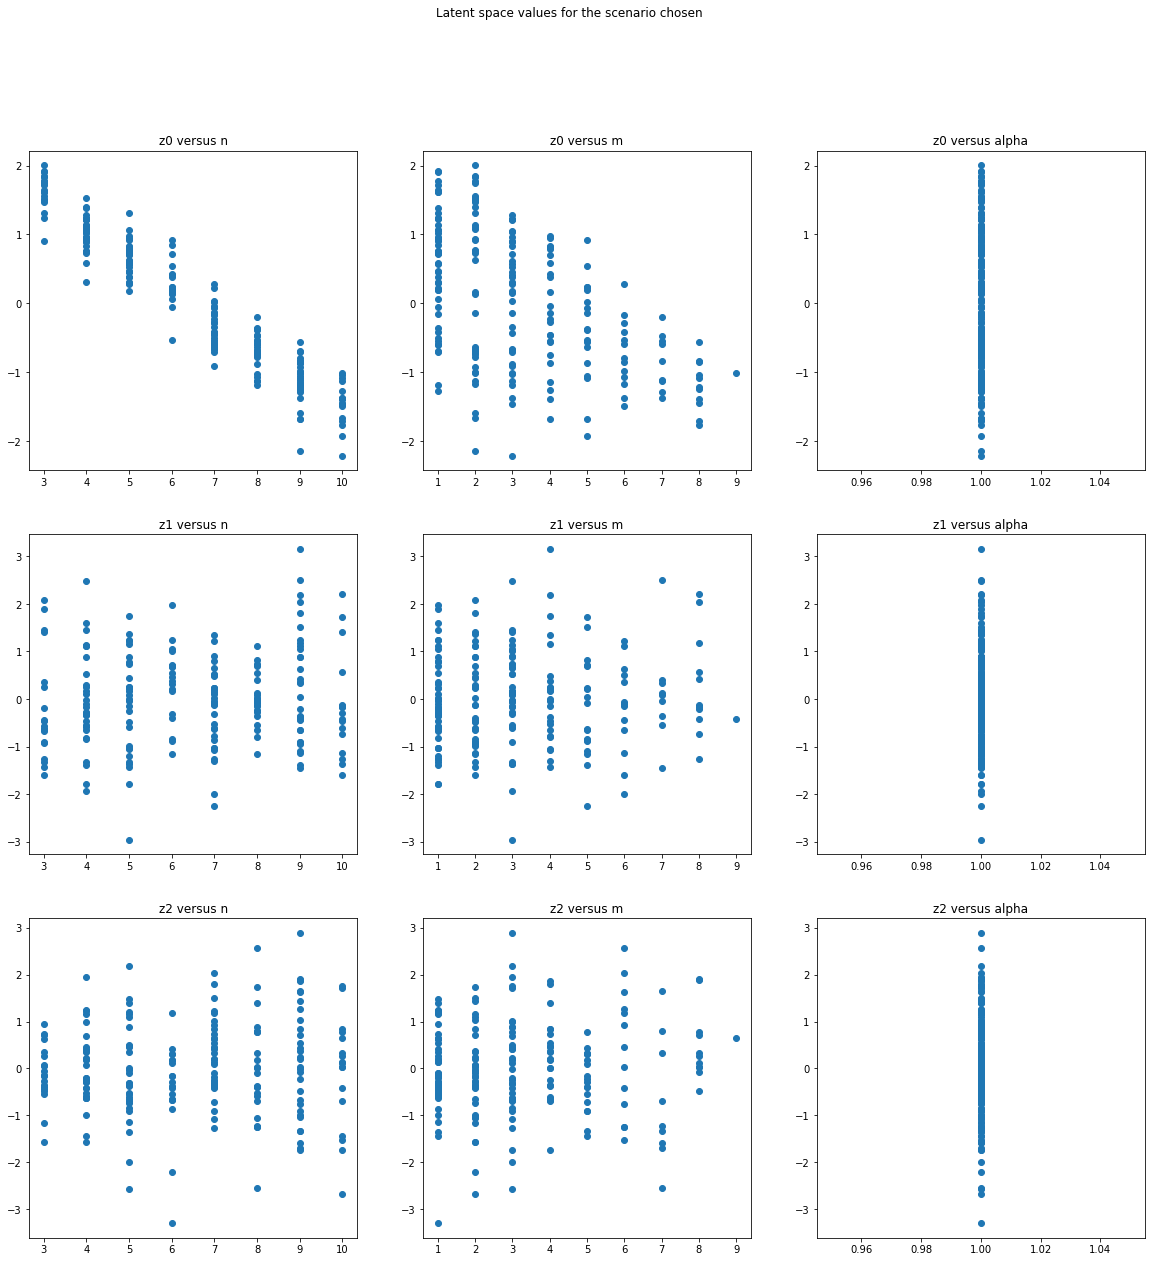

In [22]:
fig, axs = plt.subplots(LATENT_SPACE_SIZE, PARAMETER_SPACE_SIZE, figsize=(20, 20))
covariance_matrix = np.zeros((LATENT_SPACE_SIZE, PARAMETER_SPACE_SIZE))

fig.suptitle('Latent space values for the scenario chosen')
for z in range(LATENT_SPACE_SIZE):
    for p in range(PARAMETER_SPACE_SIZE):
        x = result_matrix_parameters[p, :]
        y = result_matrix_latent[z, :]
        if np.std(y) != 0:
            y = (y - np.mean(y)) / np.std(y)
        
        covariance_matrix[z, p] = np.corrcoef(y, x)[0, 1]

        axs[z, p].scatter(x, y)

        if p == 0:
            axs[z, p].set_title('z' + str(z) + ' versus n')
        if p == 1:
            axs[z, p].set_title('z' + str(z) + ' versus m')
        if p == 2:
            axs[z, p].set_title('z' + str(z) + ' versus alpha')

print()
print('Covariance matrix between the latent space and the generative parameters.')
print('The rows correspond to Z0, Z1, and Z3. The columns correspond to n, m and alpha respectively.')
print('The NaN can be interpreted as 0 correlation.')
print()
print(covariance_matrix)

## Experiment 2: Predicted Parameters

### Experiment parameters

In [23]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 200

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 150
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2
RECONSTRUCTION_NORMALIZATION = 10

## For H function
NB_EPOCHS_H = 100
BATCH_SIZE_H = 1

## Seed random number generator
SEED = 345
np.random.seed(345)
tf.random.set_seed(345)
seed(SEED)

### Compute

In [24]:
result_matrix_param_pred = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))
result_matrix_param_true = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))

# Generate train data
A_train, X_train, Y_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

# Train
model = fit_vae(A_train, X_train)

# Retrieve latent space values
graph_conv_filters = preprocess_adj_tensor_with_identity(A_train, SYM_NORM)
train = [X_train, graph_conv_filters]

latent_pred = model.get_latent_values(train)

# Train H and predict 
h_X_train = latent_pred
h_y_train = Y_train
h_model = fit_h(h_X_train, h_y_train)
h_prediction = predict_h(h_model, h_X_train)

# Store result
result_matrix_param_pred = h_prediction.T
result_matrix_param_true = Y_train.T

### Display

Result for n: (mse) 0.58 (r2) 0.8776138929332574
Result for m: (mse) 3.365 (r2) 0.2386877828054299
Result for alpha: (mse) 0.0 (r2) 1.0

Covariance vector between the true parameters and the predicted parameters
for n, m and alpha respectively:

[0.93941554 0.49142151        nan]


C:\Users\Alacrity\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


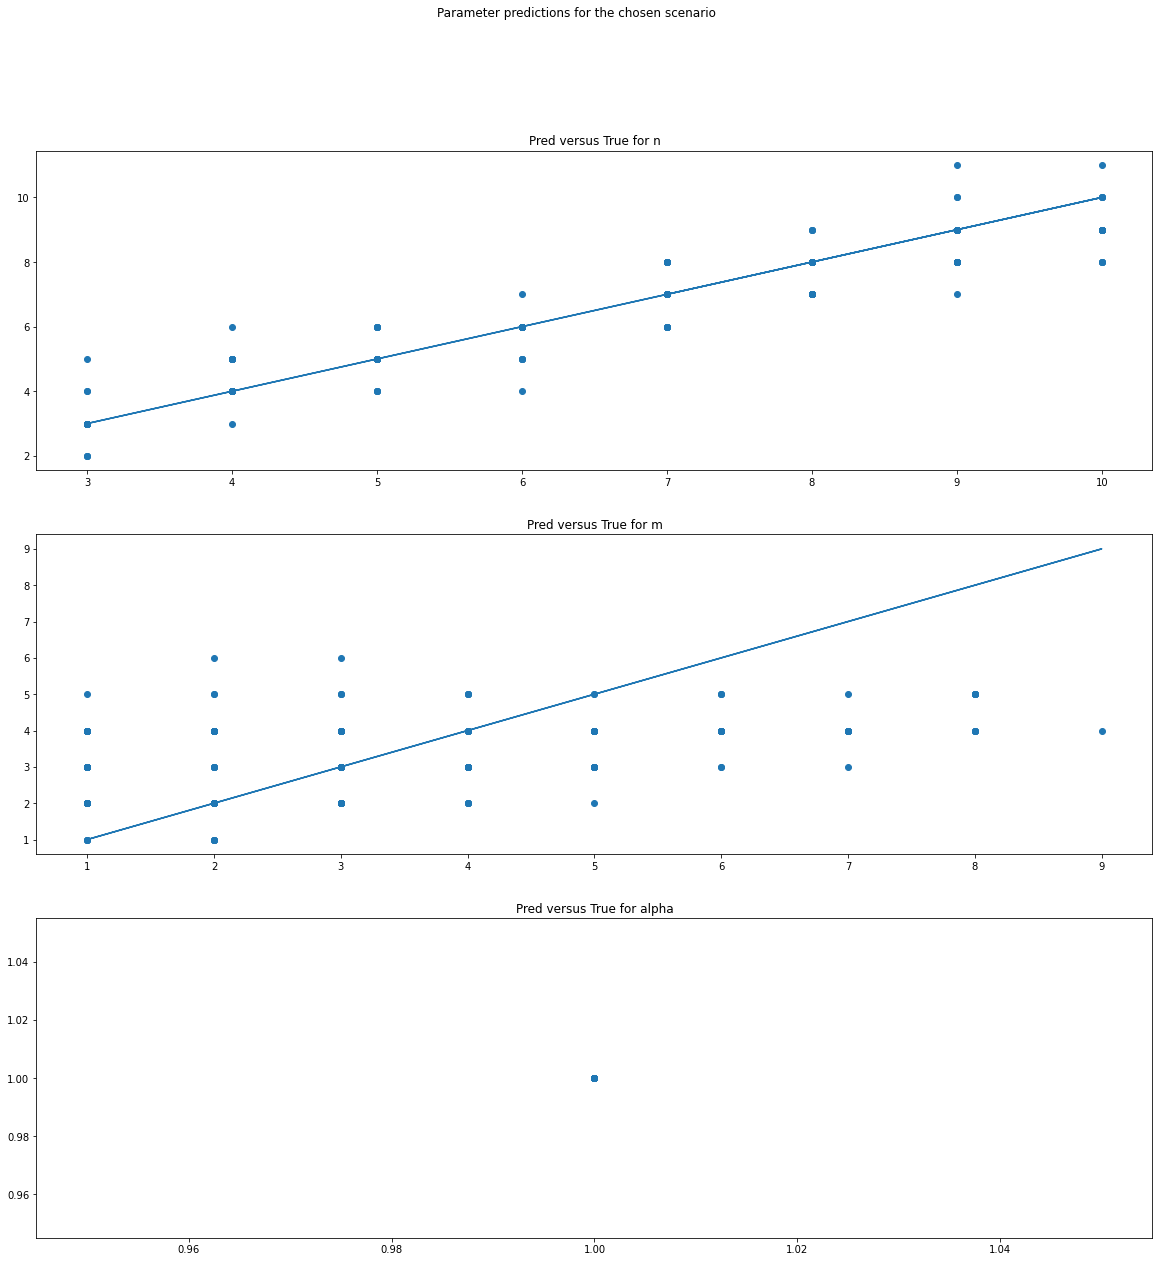

In [25]:
fig, axs = plt.subplots(PARAMETER_SPACE_SIZE, figsize=(20, 20))
covariance_vector = np.zeros((PARAMETER_SPACE_SIZE))

fig.suptitle('Parameter predictions for the chosen scenario')
for p in range(PARAMETER_SPACE_SIZE):

    x = result_matrix_param_true[p, :]
    y = result_matrix_param_pred[p, :]
    mse = mean_squared_error(x, y)
    r_squared = r2_score(x, y)
    
    covariance_vector[p] = np.corrcoef(y, x)[0, 1]

    axs[p].scatter(x, y)
    axs[p].plot(x, x)

    if p == 0:
        axs[p].set_title('Pred versus True for n')
        print('Result for n: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
    if p == 1:
        axs[p].set_title('Pred versus True for m')
        print('Result for m: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
    if p == 2:
        axs[p].set_title('Pred versus True for alpha')
        print('Result for alpha: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))

print()
print('Covariance vector between the true parameters and the predicted parameters')
print('for n, m and alpha respectively:')
print()
print(covariance_vector)